# Import Package

In [1]:
import uproot as ur
import xgboost as xgb
import pandas as pd
import numpy as np
import hyperopt as hopt
import sklearn.metrics as skm
import platform
import os
import sys
import matplotlib.pyplot as plt
import json


data_path = '/home/cmo/jb_dataspell/multilepton/best_train/Output/'
data_name = 'original_hist_'
variables = ['FlavorCat', 'met_met', 'M_llljj', 'M_lll', 'HT', 'HT_jets', 'HT_lep', 'best_Z_Mll', 'M_l0l1', 'M_l0l2', 'M_l1l2', 'dR_l0l1', 'dR_l0l2', 'dR_l1l2', 'dR_l0j', 'dR_l1j', 'dR_l2j', 'M_l0j', 'M_l1j', 'M_l2j', 'minOSMll', 'minOSSFMll']


# Train

In [2]:
class TrainProcessor:
    def __init__(
            self,
            ntuple: str,
            out_dir: str,
            k_fold: int = None,
            fold: int = None,
            svb_weight_ratio: float = 1,
            variables: list = None,
    ):
        self.ntuple = ntuple
        self.fold_name = f'fold_{fold}'
        self.out_dir = os.path.join(out_dir, self.fold_name)
        if not os.path.exists(self.out_dir):
            os.makedirs(self.out_dir)

        self.k_fold = k_fold
        self.fold = fold
        self.variables = variables
        self.weight_signal = svb_weight_ratio
        self.weight_bkg = 1


    def train(self, hyper_parameters, if_save_result=True, verbose=1):
        data_file = ur.open(self.ntuple)
        sig_train = data_file["sig_train"].arrays(library='pd')
        sig_test = data_file["sig_test"].arrays(library='pd')
        bkg_train = data_file["bkg_train"].arrays(library='pd')
        bkg_test = data_file["bkg_test"].arrays(library='pd')

        df_train = pd.concat([sig_train, bkg_train])
        self.dtrain = xgb.DMatrix(data=df_train[self.variables].to_numpy(),
                             label=np.array( [[1]*len(sig_train) + [0]*len(bkg_train)] ),
                              weight=np.concatenate([[self.weight_signal]*len(sig_train) + [self.weight_bkg]*len(bkg_train)])
                             )

        df_test = pd.concat([sig_test, bkg_test])
        self.dtest = xgb.DMatrix(data=df_test[self.variables].to_numpy(),
                                  label=np.array( [[1]*len(sig_test) + [0]*len(bkg_test)] ),
                                 weight=np.concatenate([[self.weight_signal]*len(sig_test) + [self.weight_bkg]*len(bkg_test)])
                                  )
        # Learning task parameters
        task_param = {
            'num_boost_round': 300,
            'early_stopping_rounds': 10,
            'evals': [(self.dtrain, "train"), (self.dtest, "eval")],
            'verbose_eval': False
            # 'verbose_eval': 50 if debug else False,
        }
        bst = xgb.train(hyper_parameters, self.dtrain, **task_param)


        # evaluation on test
        train_preds = bst.predict(self.dtrain, iteration_range=(0, bst.best_iteration + 1))
        test_preds = bst.predict(self.dtest, iteration_range=(0, bst.best_iteration + 1))

        loss = bst.eval(self.dtest)
        loss = float(loss.split(':')[1])

        # save result
        if if_save_result:

            bst.save_model(os.path.join(self.out_dir, 'xgboost_model.json'))

            with ur.recreate(os.path.join(self.out_dir, 'xgboost_output.root')) as f:
                test_to_save = df_test.copy()
                test_to_save['scores'] = test_preds
                test_to_save['labels'] = self.dtest.get_label()
                f["TestTree"] = test_to_save

                train_to_save = df_train.copy()
                train_to_save['scores'] = train_preds
                train_to_save['labels'] = self.dtrain.get_label()
                f["TrainTree"] = train_to_save

            print(f"===> wrote trainning result {self.out_dir}\n")
        if verbose:
            print("===> xgboost training is done!\n")
        return loss, bst



# Hyper-opt

In [3]:
class HyperOptProcessor:
    def __init__(self, config, svb_weight_ratio=1):
        self.train_param = config['optimization']['hyper_parameters']

        self.kfold = config['k_fold']
        self.variables = config['training_parameters']['variables']
        self.out_dir= config['output_path']

        self.trainers = [ TrainProcessor(os.path.join(self.out_dir, f'fold_{k}', f'{data_name}{k}.root'),
                                         self.out_dir, self.kfold, k, svb_weight_ratio=svb_weight_ratio, variables=self.variables ) for k in range(self.kfold)]

    def opt(self, max_evals: int = 10):
        def opt_train(args):
            # specify parameters
            train_param = {
                "tree_method": "gpu_hist" if platform.system() != 'Darwin' else 'hist',
                # "tree_method": "hist",
                "max_depth": int(args['max_depth']),
                "eta": float(args['eta']),
                "objective": "binary:logistic",
                'eval_metric': ['logloss'],
            }
            loss = 0
            for trianer in self.trainers:
                ls, _ = trianer.train(train_param, if_save_result=False, verbose=0)
                loss += ls
            return {'loss': loss, 'status': hopt.STATUS_OK}


        space = {
            'max_depth': hopt.hp.quniform("max_depth", *self.train_param['max_depth']),
            'eta': hopt.hp.uniform('eta', *self.train_param['eta']),
        }

        # minimize the objective over the space
        trials = hopt.Trials()

        self.best_hyperparams = hopt.fmin(fn=opt_train,
                                space=space,
                                algo=hopt.tpe.suggest,
                                max_evals=max_evals,
                                trials=trials)

        print("The best hyper parameters are : ", "\n")
        print(self.best_hyperparams)

        return trials, self.best_hyperparams

    def train_all(self, args=None):
        args = args if (args is not None) else self.best_hyperparams
        train_param = {
            "tree_method": "gpu_hist" if platform.system() != 'Darwin' else 'hist',
            # "tree_method": "hist",
            "max_depth": int(args['max_depth']),
            "eta": float(args['eta']),
            "objective": "binary:logistic",
            'eval_metric': ['logloss'],
        }


        loss = 0
        outfile_list = []
        for k, trainer in enumerate(self.trainers):
            trainer.out_dir = os.path.join(self.out_dir, f'fold_{k}')
            ls, _ = trainer.train(train_param, if_save_result=True, verbose=1)
            print(f'fold_{k} loss: {ls}')
            loss += ls
            outfile_list.append(os.path.join(trainer.out_dir, 'xgboost_output.root'))
        print(f'total loss: {loss}')


        merge_target = os.path.join(self.out_dir, 'eval/xgboost_output.root')
        # Define the list of trees to concatenate
        tree_names = ["TestTree", "TrainTree"]


        # Loop over the input files and concatenate the TestTrees
        test_trees = []
        train_trees = []
        files = [ur.open(file_name) for file_name in outfile_list]

        with ur.recreate(merge_target) as output:
            output["TestTree"] = ur.concatenate([file['TestTree'] for file in files])
            output["TrainTree"] = ur.concatenate([file['TrainTree'] for file in files])








# Evaluation

In [4]:
def eval_scores( in_data: str, out_d:str = './', do_plot: bool = True):
    result = {
        'auc': 0.,
        'significance': 0.,
        'mva_score': -999,
    }
    res = ur.open(in_data)

    scores, labels, weight = res['TestTree'].arrays(['scores', 'labels', 'weight'], library='np').values()
    train_scores, train_labels, train_weight = res['TrainTree'].arrays(['scores', 'labels', 'weight'], library='np').values()
    """
    ROC Curve
    """
    fpr, tpr, thresholds = skm.roc_curve(labels, scores, sample_weight=weight, pos_label=1)
    # auc = skm.auc(fpr, tpr)
    auc = np.trapz(tpr, fpr)

    if do_plot:
        mycolors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
        mylinestyles = ['dashed', 'dashed', 'dashed', 'solid']
        mylinewidth = [1.5, 1.5, 1.5, 2.5]
        plots = (fpr, tpr, auc)
        fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=80)

        plt.plot(
            plots[0], plots[1],
            label=f"AUC = {plots[2]:.3f}",
            color=mycolors[0],
            linestyle=mylinestyles[0],
            linewidth=mylinewidth[0],
        )

        result['auc'] = plots[2]

        plt.ylabel('Signal Eff.')
        plt.xlabel('Background InEff.')
        plt.legend(loc=4)
        plt.show()
        fig.savefig(os.path.join(out_d, 'roc.svg'), format='svg')

    """
    Significance Curve
    """
    sig_score = scores[np.where(labels==1)]
    bkg_score = scores[np.where(labels==0)]
    sig_weight, bkg_weight = np.ones(len(sig_score)), np.ones(len(bkg_score))
    if weight is not None:
        sig_weight = weight[np.where(labels==1)]
        bkg_weight = weight[np.where(labels==0)]

    bins = np.linspace(0, 1, num=200, endpoint=True)
    hist_sig, _ = np.histogram(sig_score, bins=bins, weights=sig_weight)
    hist_bkg, _ = np.histogram(bkg_score, bins=bins, weights=bkg_weight)
    s = np.cumsum(hist_sig[::-1])[::-1]
    b = np.cumsum(hist_bkg[::-1])[::-1]


    sig_err = np.sqrt(np.histogram(sig_score, bins=bins, weights=sig_weight ** 2)[0])
    bkg_err = np.sqrt(np.histogram(bkg_score, bins=bins, weights=bkg_weight ** 2)[0])
    s_err = np.sqrt(np.cumsum(sig_err[::-1] ** 2)[::-1])
    b_err = np.sqrt(np.cumsum(bkg_err[::-1] ** 2)[::-1])

    significance = (s / np.sqrt(s + b))
    significance[np.isnan(significance)] = 0

    def sig_unc(s, b, ds, db):
        t1 = ((np.sqrt(s + b) - s / (2 * np.sqrt(s + b))) / (s + b) * ds) ** 2
        t2 = (-(s * 1. / (2 * np.sqrt(s + b)) / (s + b)) * db) ** 2
        return np.sqrt(t1 + t2)

    significance_err = sig_unc(s, b, s_err, b_err)
    significance_err[np.isnan(significance_err)] = 0
    significance_with_min_bkg = max([(y, x) for x, y in enumerate(significance) if b[x] > 1.0])

    result['significance'] = significance_with_min_bkg[0]
    result['significance_no_protect'] = max(significance)
    result['mva_score'] = bins[1 + significance_with_min_bkg[1]]
    result['mva_score_no_protect'] = bins[1 + np.argmax(significance)]


    if do_plot:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=80)
        plt.plot(bins[1:], significance, color='#3776ab')
        plt.fill_between(
            bins[1:], significance - significance_err, significance + significance_err, alpha=0.35,
            edgecolor='#3776ab', facecolor='#3776ab', hatch='///', linewidth=0, interpolate=True
        )

        plt.vlines(
            x=result['mva_score'], ymin=0, ymax=result['significance'],
            colors='purple',
            label=f'max Sig. = {result["significance"]:.3f} at {result["mva_score"]:.2f}'
        )

        plt.ylabel('Significance')
        plt.xlabel('MVA score')
        plt.legend(loc=3)
        plt.show()
        fig.savefig(os.path.join(out_d, 'sig.svg'), format='svg')

        """
        Train Test Histogram
        """
        if do_plot:
            fig, (ax1, ax2) = plt.subplots(
                2, 1, figsize=(8, 10), dpi=80,
                sharex=True, gridspec_kw={'height_ratios': [4, 1]}
            )

            bins = np.linspace(0, 1, num=25, endpoint=True)
            bin_center = (bins[:-1] + bins[1:]) / 2.
            bin_err = bins[1:] - bin_center
            hist_style = dict(
                bins=bins,
                density=True, alpha=0.75, histtype='step', linewidth=2.5
            )

            # for test
            bkg = bkg_score
            sig = sig_score

            hist_sig = np.histogram(sig, bins=bins, weights=sig_weight, density=True)[0]
            hist_bkg = np.histogram(bkg, bins=bins, weights=bkg_weight, density=True)[0]
            sf_s = np.sum(hist_sig) / np.sum(sig)
            sf_b = np.sum(hist_bkg) / np.sum(bkg)
            sig_err = np.sqrt(np.histogram(sig, bins=bins, weights=sig_weight ** 2)[0]) * sf_s
            bkg_err = np.sqrt(np.histogram(bkg, bins=bins, weights=bkg_weight ** 2)[0]) * sf_b
            ax1.errorbar(
                bin_center, hist_sig, yerr=sig_err, xerr=bin_err, color='red', label='sig: test',
                marker='.', alpha=0.75, elinewidth=2, markersize=10, ls='none')
            ax1.errorbar(
                bin_center, hist_bkg, yerr=bkg_err, xerr=bin_err, color='blue', label='bkg: test',
                marker='.', alpha=0.75, elinewidth=2, markersize=10, ls='none')

            # for train
            if train_scores is not None:
                train_bkg = np.where(train_labels==0)
                bkg = train_scores[train_bkg]
                bkg_weight = train_weight[train_bkg]

                train_sig = np.where(train_labels==1)
                sig_weight = train_weight[train_sig]
                sig = train_scores[train_sig]

                s, _, _ = ax1.hist(sig, weights=sig_weight, color='red', label='sig: train', **hist_style)
                b, _, _ = ax1.hist(bkg, weights=bkg_weight, color='blue', label='bkg: train', **hist_style)
                sf_s = np.sum(s) / np.sum(sig)
                sf_b = np.sum(b) / np.sum(bkg)
                s_err = np.sqrt(np.histogram(sig, bins=bins, weights=sig_weight ** 2)[0]) * sf_s
                b_err = np.sqrt(np.histogram(bkg, bins=bins, weights=bkg_weight ** 2)[0]) * sf_b
                ax1.fill_between(
                    bin_center, s - s_err, s + s_err, alpha=0.5, facecolor='red', edgecolor='red',
                    hatch='///', linewidth=0
                )
                ax1.fill_between(
                    bin_center, b - b_err, b + b_err, alpha=0.5, facecolor='blue', edgecolor='blue',
                    hatch='///', linewidth=0
                )

                from scipy import stats
                ks_sig = stats.kstest(hist_sig, s)
                ks_bkg = stats.kstest(hist_bkg, b)

                print('signal: ', ks_sig)
                print('background: ', ks_bkg)

                def divide_unc(a, b, da, db):
                    return np.sqrt((1. / b * da) ** 2 + (-(a / b ** 2) * db) ** 2)

                ratio_s = hist_sig / s
                ratio_b = hist_bkg / b
                ratio_s_unc = divide_unc(hist_sig, s, sig_err, s_err)
                ratio_b_unc = divide_unc(hist_bkg, b, bkg_err, b_err)
                ratio_s[np.isnan(ratio_s)] = 0.0
                ratio_b[np.isnan(ratio_b)] = 0.0
                ratio_s_unc[np.isnan(ratio_s_unc)] = 0
                ratio_b_unc[np.isnan(ratio_b_unc)] = 0

                # ratio plot
                ax2.errorbar(
                    bin_center, ratio_s, yerr=ratio_s_unc, color='red', label='sig: test',
                    marker='o', alpha=0.75, ls='none')
                ax2.errorbar(
                    bin_center, ratio_b, yerr=ratio_b_unc, color='blue', label='bkg: test',
                    marker='o', alpha=0.75, ls='none')
                ax2.set_ylim([0.75, 1.25])
                ax2.axhline(
                    xmin=-1.0, xmax=1.0, y=1.0,
                    c='lightgrey',
                    ls='--'
                )
                ax2.set_ylabel('test / train')

            plt.xlabel('MVA score')
            ax1.legend(loc=1)
            plt.subplots_adjust(wspace=0, hspace=0.1)
            plt.show()
            fig.savefig(os.path.join(out_d, 'mva_hist.svg'), format='svg')

            """
            Output JSON
            """
            # Serializing json
            json_object = json.dumps(result, indent=4)

            # Writing to sample.json
            with open(os.path.join(out_d, 'result.json'), "w") as outfile:
                outfile.write(json_object)

    return result


# label = dataset['dtest'].get_label()
# eval_scores(preds, label)

In [5]:
max([(0,100), (1,100)])

(1, 100)

# Main Func

In [6]:


config = dict(
    k_fold = 3,
    output_path='xgboost_train/Output/',

    training_parameters=dict(
        variables=['FlavorCat', 'met_met', 'M_llljj', 'M_lll', 'HT', 'HT_jets', 'HT_lep', 'best_Z_Mll', 'M_l0l1', 'M_l0l2', 'M_l1l2', 'dR_l0l1', 'dR_l0l2', 'dR_l1l2', 'dR_l0j', 'dR_l1j', 'dR_l2j', 'M_l0j', 'M_l1j', 'M_l2j', 'minOSMll', 'minOSSFMll']
    ),
    optimization=dict(
        hyper_parameters={
            "max_depth": [2, 10, 1],
            "eta": [0.05, 0.5],
        }
    )
)
optimizer = HyperOptProcessor(config, svb_weight_ratio=9)
result, best_param = optimizer.opt(100)

100%|██████████| 100/100 [14:26<00:00,  8.67s/trial, best loss: 1.1071887883634122]
The best hyper parameters are :  

{'eta': 0.08307991874745715, 'max_depth': 5.0}


In [8]:
optimizer.train_all(best_param)

===> wrote trainning result xgboost_train/Output/fold_0

===> xgboost training is done!

fold_0 loss: 0.3701097230665643
===> wrote trainning result xgboost_train/Output/fold_1

===> xgboost training is done!

fold_1 loss: 0.36730873408378956
===> wrote trainning result xgboost_train/Output/fold_2

===> xgboost training is done!

fold_2 loss: 0.36977033121305836
total loss: 1.1071887883634122


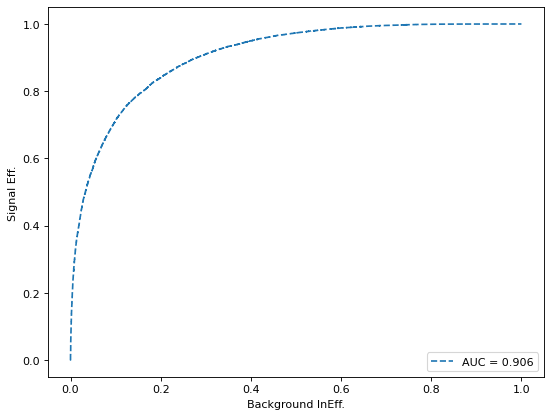

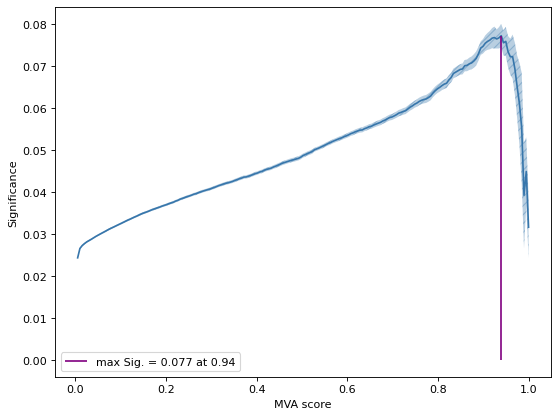

signal:  KstestResult(statistic=0.16666666666666666, pvalue=0.9024001944012529)
background:  KstestResult(statistic=0.08333333333333333, pvalue=0.9999994797375902)


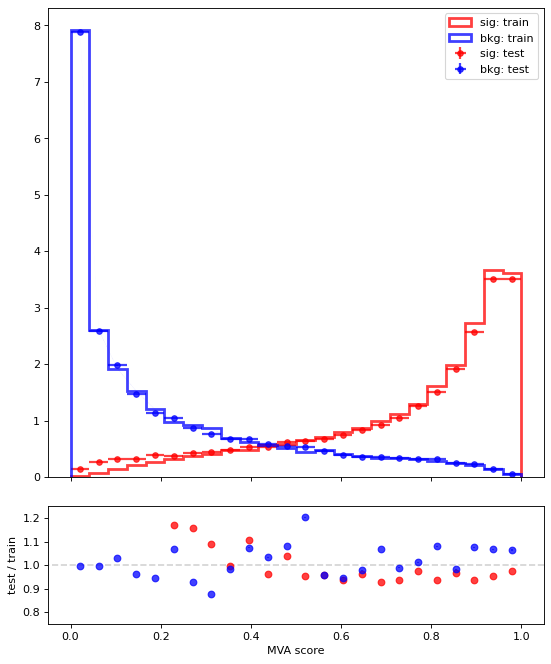

{'auc': 0.9064045546772823,
 'significance': 0.07732741390578102,
 'mva_score': 0.9396984924623115,
 'significance_no_protect': 0.07732741390578102,
 'mva_score_no_protect': 0.9396984924623115}

In [9]:
# # Single Train
# fold = 0
# train_param = {
#     "tree_method": "gpu_hist" if platform.system() != 'Darwin' else 'hist',
#     # "tree_method": "hist",
#     # "max_depth": 8,
#     "max_depth": 7,
#     # "eta": 0.1,
#     "eta": 0.062151689630760516,
#     "objective": "binary:logistic",
#     'eval_metric': ['logloss'],
# }
# trainer = TrainProcessor(os.path.join(data_path, f'fold_{fold}', f'{data_name}{fold}.root'), 'xgboost_train/Output', 3, fold, variables=variables)
# loss, bst = trainer.train(train_param, True)
# print(f'loss: {loss}')
eval_scores(f'xgboost_train/Output/eval/xgboost_output.root', out_d='xgboost_train/Output/eval/', do_plot=True)


# Dataset

In [8]:
def get_dataset(entry_start=0, entry_stop=None):
    data_file = ur.open(os.path.join(data_path, 'fold_0', data_name))
    in_feature = data_file["sig_train"].keys()[2:]
    print(f"features: {in_feature}")

    entry_stop = entry_stop if entry_stop!=0 else data_file['sig_train'].num_entries

    sig_train = dict(
        data = np.stack(list(data_file["sig_train"].arrays(in_feature, entry_start=entry_start, entry_stop=entry_stop, library='numpy').values()), axis=1),
        weight = data_file["sig_train"].arrays("weight", entry_start=entry_start, entry_stop=entry_stop, library='numpy')['weight']
    )
    bkg_train = dict(
        data = np.stack(list(data_file["bkg_train"].arrays(in_feature, entry_start=entry_start, entry_stop=entry_stop, library='numpy').values()), axis=1),
        weight = data_file["bkg_train"].arrays("weight", entry_start=entry_start, entry_stop=entry_stop, library='numpy')['weight']
    )
    sig_test = dict(
        data = np.stack(list(data_file["sig_test"].arrays(in_feature, entry_start=entry_start, entry_stop=entry_stop, library='numpy').values()), axis=1),
        weight = data_file["sig_test"].arrays("weight", entry_start=entry_start, entry_stop=entry_stop, library='numpy')['weight']
    )
    bkg_test = dict(
        data = np.stack(list(data_file["bkg_test"].arrays(in_feature, entry_start=entry_start, entry_stop=entry_stop, library='numpy').values()), axis=1),
        weight = data_file["bkg_test"].arrays("weight", entry_start=entry_start, entry_stop=entry_stop, library='numpy')['weight']
    )


    dataset = dict(
        dtrain = xgb.DMatrix(data=np.concatenate([sig_train['data'], bkg_train['data']], axis=0),
                             label=np.concatenate([np.ones(len(sig_train['data'])), np.zeros(len(bkg_train['data']))]),
                             # weight=np.concatenate([sig_train['weight'], bkg_train['weight']], axis=0)
                             ),
        dtest = xgb.DMatrix(data=np.concatenate([sig_test['data'], bkg_test['data']], axis=0),
                            label=np.concatenate([np.ones(len(sig_test['data'])), np.zeros(len(bkg_test['data']))]),
                            # weight=np.concatenate([sig_test['weight'], bkg_test['weight']], axis=0)
                            ),
    )
    return dataset, dict(sig_train=sig_train, bkg_train=bkg_train, sig_test=sig_test, bkg_test=bkg_test)

In [57]:
entry_start, entry_stop = 0, 1000
dataset, all_datasets = get_dataset(entry_start, entry_stop)

features: ['FlavorCat', 'met_met', 'M_llljj', 'M_lll', 'HT', 'HT_jets', 'HT_lep', 'best_Z_Mll', 'M_l0l1', 'M_l0l2', 'M_l1l2', 'dR_l0l1', 'dR_l0l2', 'dR_l1l2', 'dR_l0j', 'dR_l1j', 'dR_l2j', 'M_l0j', 'M_l1j', 'M_l2j', 'minOSMll', 'minOSSFMll']


# Train and Opt Functions

In [23]:
def train_xgboost(dtrain: xgb.DMatrix = None, dtest: xgb.DMatrix = None, train_param=None, debug=False):
    # Learning task parameters
    task_param = {
        'num_boost_round': 300,
        'early_stopping_rounds': 10,
        'evals': [(dtrain, "train"), (dtest, "eval")],
        'verbose_eval': 50 if debug else False,
    }
    eval_results = {}
    bst = xgb.train(train_param, dtrain, **task_param, evals_result=eval_results)

    # evaluation on test
    preds = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
    return preds, bst, eval_results

def opt_train(args):
    # specify parameters
    train_param = {
        "tree_method": "gpu_hist" if platform.system() != 'Darwin' else 'hist',
        # "tree_method": "hist",
        "max_depth": int(args['max_depth']),
        "eta": float(args['eta']),
        "objective": "binary:logistic",
        'eval_metric': ['logloss'],
        # 'scale_pos_weight': args['weight_balance'],
    }

    total_eff, eff_dict, bst, bkg_cut = train_xgboost(train_param=train_param, **args['dataset'])

    return {'loss': -total_eff, 'status': hopt.STATUS_OK, 'eff': eff_dict, 'best_model': bst, 'bkg_cut': bkg_cut}



In [24]:
train_param = {
    "tree_method": "gpu_hist" if platform.system() != 'Darwin' else 'hist',
    # "tree_method": "hist",
    "max_depth": 8,
    "eta": 0.1,
    "objective": "binary:logistic",
    'eval_metric': ['logloss'],
}
preds, bst, eval_results = train_xgboost(**dataset, train_param=train_param, debug=True)

NameError: name 'train_xgboost' is not defined

In [61]:
bst.best_trial

AttributeError: 'Booster' object has no attribute 'best_trial'

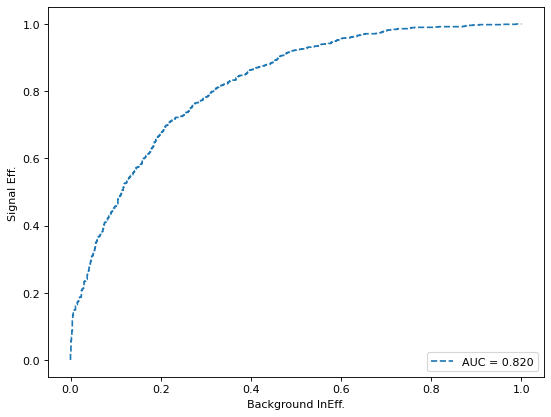

/tmp/ipykernel_343/494386886.py:61: RuntimeWarning: invalid value encountered in divide
  significance = (s / np.sqrt(s + b))
/tmp/ipykernel_343/494386886.py:65: RuntimeWarning: invalid value encountered in divide
  t1 = ((np.sqrt(s + b) - s / (2 * np.sqrt(s + b))) / (s + b) * ds) ** 2
/tmp/ipykernel_343/494386886.py:66: RuntimeWarning: invalid value encountered in divide
  t2 = (-(s * 1. / (2 * np.sqrt(s + b)) / (s + b)) * db) ** 2


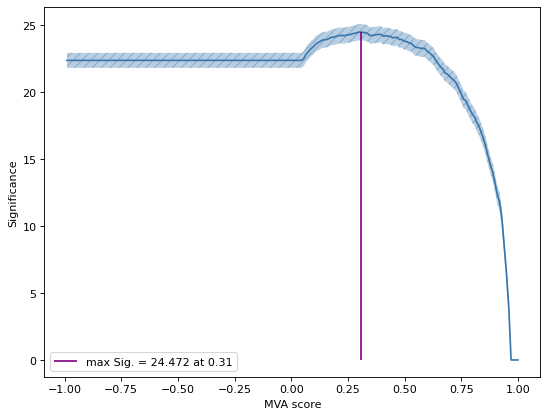

{'auc': 0.8204685,
 'significance': 24.471889803567272,
 'mva_score': 0.306532663316583,
 'significance_no_protect': 24.471889803567272,
 'mva_score_no_protect': 0.306532663316583}

In [63]:
def eval_scores(scores: np.array, labels: np.array, weight: np.array = None, do_plot: bool = True):
    result = {
        'auc': 0.,
        'significance': 0.,
        'mva_score': -999,
    }
    """
    ROC Curve
    """
    fpr, tpr, thresholds = skm.roc_curve(labels, scores, sample_weight=weight, pos_label=1)
    auc = skm.auc(fpr, tpr)

    if do_plot:
        mycolors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
        mylinestyles = ['dashed', 'dashed', 'dashed', 'solid']
        mylinewidth = [1.5, 1.5, 1.5, 2.5]
        plots = (fpr, tpr, auc)
        fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=80)

        plt.plot(
            plots[0], plots[1],
            label=f"AUC = {plots[2]:.3f}",
            color=mycolors[0],
            linestyle=mylinestyles[0],
            linewidth=mylinewidth[0],
        )

        result['auc'] = plots[2]

        plt.ylabel('Signal Eff.')
        plt.xlabel('Background InEff.')
        plt.legend(loc=4)
        plt.show()
        # fig.savefig(os.path.join(out_d, 'roc.svg'), format='svg')

    """
    Significance Curve
    """
    sig_score = scores[np.where(labels==1)]
    bkg_score = scores[np.where(labels==0)]
    sig_weight, bkg_weight = np.ones(len(sig_score)), np.ones(len(bkg_score))
    if weight is not None:
        sig_weight = weight[np.where(labels==1)]
        bkg_weight = weight[np.where(labels==0)]

    bins = np.linspace(-1, 1, num=200, endpoint=True)
    hist_sig, _ = np.histogram(sig_score, bins=bins, weights=sig_weight)
    hist_bkg, _ = np.histogram(bkg_score, bins=bins, weights=bkg_weight)
    s = np.cumsum(hist_sig[::-1])[::-1]
    b = np.cumsum(hist_bkg[::-1])[::-1]


    sig_err = np.sqrt(np.histogram(sig_score, bins=bins, weights=sig_weight ** 2)[0])
    """
    WHY? WAITING TO BE CHECKED!
    """
    bkg_err = np.sqrt(np.histogram(sig_score, bins=bins, weights=sig_weight ** 2)[0])
    s_err = np.sqrt(np.cumsum(sig_err[::-1] ** 2)[::-1])
    b_err = np.sqrt(np.cumsum(bkg_err[::-1] ** 2)[::-1])

    significance = (s / np.sqrt(s + b))
    significance[np.isnan(significance)] = 0

    def sig_unc(s, b, ds, db):
        t1 = ((np.sqrt(s + b) - s / (2 * np.sqrt(s + b))) / (s + b) * ds) ** 2
        t2 = (-(s * 1. / (2 * np.sqrt(s + b)) / (s + b)) * db) ** 2
        return np.sqrt(t1 + t2)

    significance_err = sig_unc(s, b, s_err, b_err)
    significance_err[np.isnan(significance_err)] = 0
    significance_with_min_bkg = max([(y, x) for x, y in enumerate(significance) if b[x] > 1.0])

    result['significance'] = significance_with_min_bkg[0]
    result['significance_no_protect'] = max(significance)
    result['mva_score'] = bins[1 + significance_with_min_bkg[1]]
    result['mva_score_no_protect'] = bins[1 + np.argmax(significance)]


    if do_plot:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=80)
        plt.plot(bins[1:], significance, color='#3776ab')
        plt.fill_between(
            bins[1:], significance - significance_err, significance + significance_err, alpha=0.35,
            edgecolor='#3776ab', facecolor='#3776ab', hatch='///', linewidth=0, interpolate=True
        )

        plt.vlines(
            x=result['mva_score'], ymin=0, ymax=result['significance'],
            colors='purple',
            label=f'max Sig. = {result["significance"]:.3f} at {result["mva_score"]:.2f}'
        )

        plt.ylabel('Significance')
        plt.xlabel('MVA score')
        plt.legend(loc=3)
        plt.show()
        # fig.savefig(os.path.join(out_d, 'sig.svg'), format='svg')

    return result


label = dataset['dtest'].get_label()
eval_scores(preds, label)

In [29]:
# preds
label = dataset['dtest'].get_label()
fpr, tpr, thresholds = skm.roc_curve(label, preds, pos_label=1)
# skm.roc_curve(label, preds, pos_label=1)

In [6]:
to_save = pd.DataFrame({'a':np.arange(10), 'b':np.arange(10,20)})
preds = np.random.rand(10)
with ur.recreate(os.path.join('test.root')) as f:
    to_save['scores'] = preds
    f["mytree"] = to_save